In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Create output directory for figures
output_dir = "./spotify_classification_analysis"
os.makedirs(output_dir, exist_ok=True)

print("Starting Spotify Chart Classification Analysis...")

# Step 1: Load datasets
print("\n===== LOADING DATASETS =====")

# Set up the output directory for figures
output_dir = "./spotify_analysis_figures"
os.makedirs(output_dir, exist_ok=True)

print("Starting Spotify Music Features Analysis...")

# Load the dedupe_best_rank dataset
print("\n===== LOADING DATA =====")

# Adjust the path to match your file location
rank_parquet_files = glob.glob("./dedupe_best_rank/part-*.parquet")
rank_df_list = []

for file in rank_parquet_files:
    # Only process files from dedupe_best_rank folder
    if "dedupe_best_rank" in file:
        df = pd.read_parquet(file)
        rank_df_list.append(df)

if len(rank_df_list) > 0:
    rank_df = pd.concat(rank_df_list, ignore_index=True)
    print(f"Loaded rank dataset with {len(rank_df)} rows and {len(rank_df.columns)} columns")
else:
    print("No rank dataset files found. Check the file paths.")
    rank_df = None

# Load rank dataset (already loaded as rank_df)
print(f"Rank dataset loaded: {len(rank_df)} rows")

# Load the second dataset with all songs (adjust path as needed)
all_songs_path = "path_to_your_second_dataset.csv"  # Adjust this path
all_songs_df = pd.read_csv("./tracks_features.csv")
print(f"All songs dataset loaded: {len(all_songs_df)} rows")

# Step 2: Filter songs from 2015-2021 in the all songs dataset
print("\n===== FILTERING SONGS BY YEAR =====")
all_songs_df = all_songs_df[(all_songs_df['year'] >= 2015) & (all_songs_df['year'] <= 2021)]
print(f"Songs from 2015-2021: {len(all_songs_df)}")

# Step 3: Extract unique artists from the rank dataset
rank_artists = set()
# The artists column might contain multiple artists separated by commas or other characters
for artists_str in rank_df['artist'].dropna().unique():
    # Split and clean artist names (adjust the splitting logic based on your data format)
    artists = [artist.strip() for artist in artists_str.split(',')]
    rank_artists.update(artists)

print(f"Extracted {len(rank_artists)} unique artists from the rank dataset")

# Step 4: Filter songs from the all_songs_df that belong to the artists in rank_artists
# The approach depends on how artists are stored in all_songs_df
filtered_songs = []
for _, song in all_songs_df.iterrows():
    # Check if any of the ranked artists are in this song's artists
    song_artists = song['artists']
    # Assuming 'artists' column contains artist names as a string
    # Adjust the logic based on your data format
    if any(artist in song_artists for artist in rank_artists):
        filtered_songs.append(song)

filtered_songs_df = pd.DataFrame(filtered_songs)
print(f"Songs by ranked artists: {len(filtered_songs_df)}")

# Step 5: Create labels - check if songs are in the rank dataset
# Convert track_ids to sets for faster lookup
ranked_track_ids = set(rank_df['track_id'])

# Add label column (1 if song is in rank_df, 0 otherwise)
filtered_songs_df['is_ranked'] = filtered_songs_df['id'].apply(lambda x: 1 if x in ranked_track_ids else 0)

# Count ranked vs. non-ranked
ranked_count = filtered_songs_df['is_ranked'].sum()
print(f"Songs that appeared in rankings: {ranked_count}")
print(f"Songs that did not appear in rankings: {len(filtered_songs_df) - ranked_count}")

Starting Spotify Chart Classification Analysis...

===== LOADING DATASETS =====
Starting Spotify Music Features Analysis...

===== LOADING DATA =====
Loaded rank dataset with 197940 rows and 20 columns
Rank dataset loaded: 197940 rows
All songs dataset loaded: 1204025 rows

===== FILTERING SONGS BY YEAR =====
Songs from 2015-2021: 338462
Extracted 75315 unique artists from the rank dataset
Songs by ranked artists: 310760
Songs that appeared in rankings: 7526
Songs that did not appear in rankings: 303234


In [2]:
rank_df.describe()

,rank,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature
count,197940.000000,197940.000000,197940.000000,197940.000000,197940.000000,197940.000000,197940.000000,197940.000000,197940.000000,197940.000000,197940.000000,197940.000000,197940.000000
mean,47.148232,0.650771,0.633611,5.325690,-7.344648,0.560791,0.118441,0.281382,0.046537,0.178613,0.499742,121.472006,3.952132
std,49.528586,0.153493,0.193092,3.603628,3.340280,0.496292,0.119096,0.272675,0.172961,0.142169,0.231210,28.603311,0.324861
min,1.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.552000,0.514000,2.000000,-8.716000,0.000000,0.039100,0.051600,0.000000,0.095800,0.320000,98.961000,4.000000
50%,30.000000,0.668000,0.652000,6.000000,-6.764500,1.000000,0.063800,0.187000,0.000001,0.122000,0.494000,120.042000,4.000000
75%,54.000000,0.765000,0.778000,8.000000,-5.233000,1.000000,0.157000,0.452000,0.000270,0.214000,0.678000,139.990000,4.000000
max,200.000000,0.988000,1.000000,11.000000,2.240000,1.000000,0.966000,0.996000,0.993000,0.996000,0.999000,238.431000,5.000000


In [3]:
rank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197940 entries, 0 to 197939
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   track_id             197940 non-null  object 
 1   title                197939 non-null  object 
 2   artist               197939 non-null  object 
 3   rank                 197940 non-null  int32  
 4   date                 197940 non-null  object 
 5   region               197940 non-null  object 
 6   chart                197940 non-null  object 
 7   album                197617 non-null  object 
 8   af_danceability      197940 non-null  float64
 9   af_energy            197940 non-null  float64
 10  af_key               197940 non-null  float64
 11  af_loudness          197940 non-null  float64
 12  af_mode              197940 non-null  float64
 13  af_speechiness       197940 non-null  float64
 14  af_acousticness      197940 non-null  float64
 15  af_instrumentalne

=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   track_id             9838 non-null   object 
 1   title                9838 non-null   object 
 2   artist               9838 non-null   object 
 3   rank                 9838 non-null   int32  
 4   date                 9838 non-null   object 
 5   region               9838 non-null   object 
 6   chart                9838 non-null   object 
 7   album                9820 non-null   object 
 8   af_danceability      9838 non-null   float64
 9   af_energy            9838 non-null   float64
 10  af_key               9838 non-null   float64
 11  af_loudness          9838 non-null   float64
 12  af_mode              9838 non-null   float64
 13  af_speechiness       9838 non-null   float64
 14  af_acousticness      9838 non-null   float64
 15  af_instrumentalness

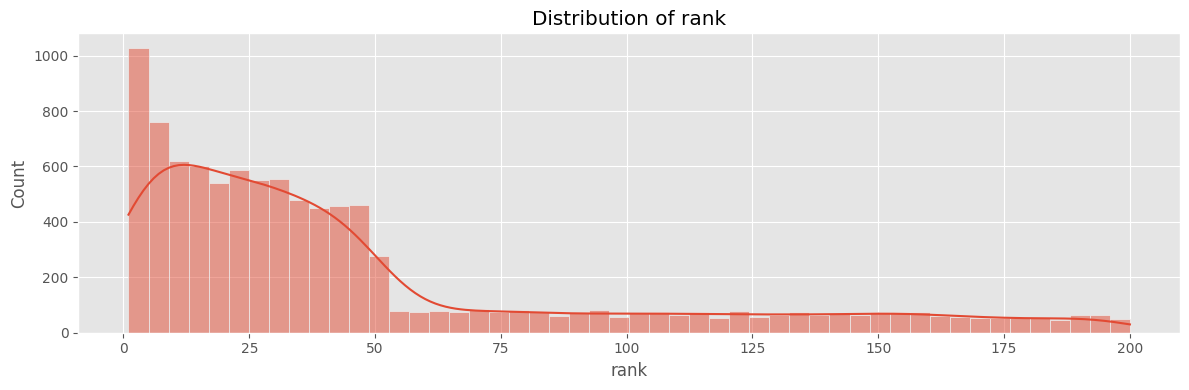

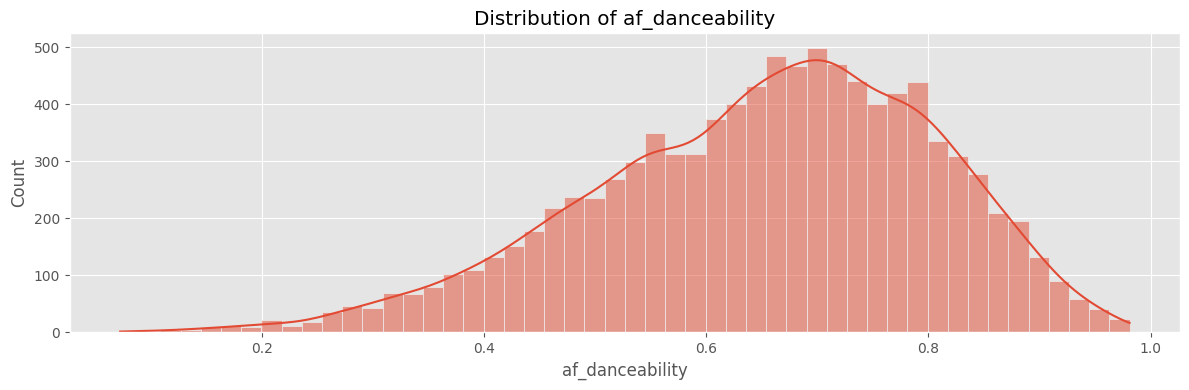

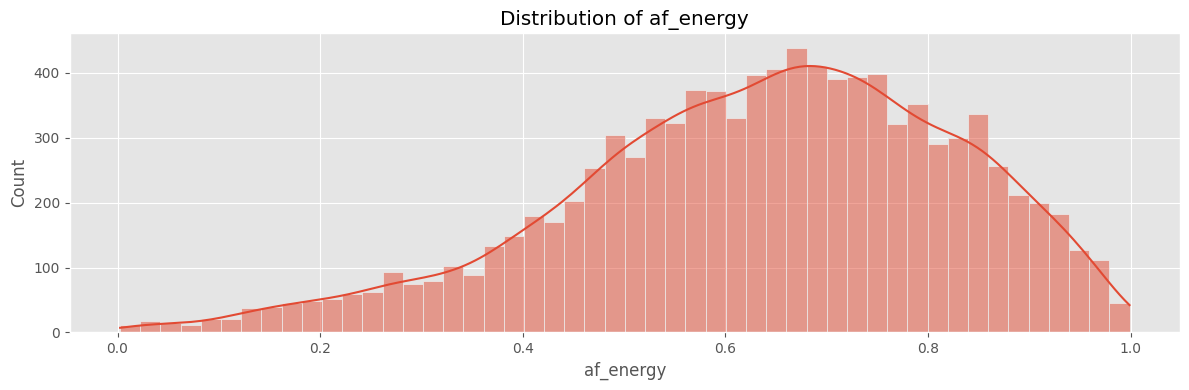

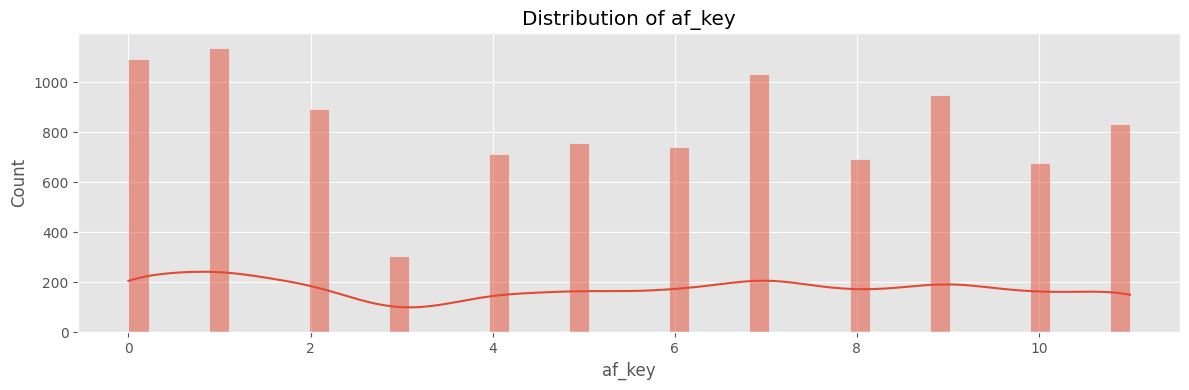

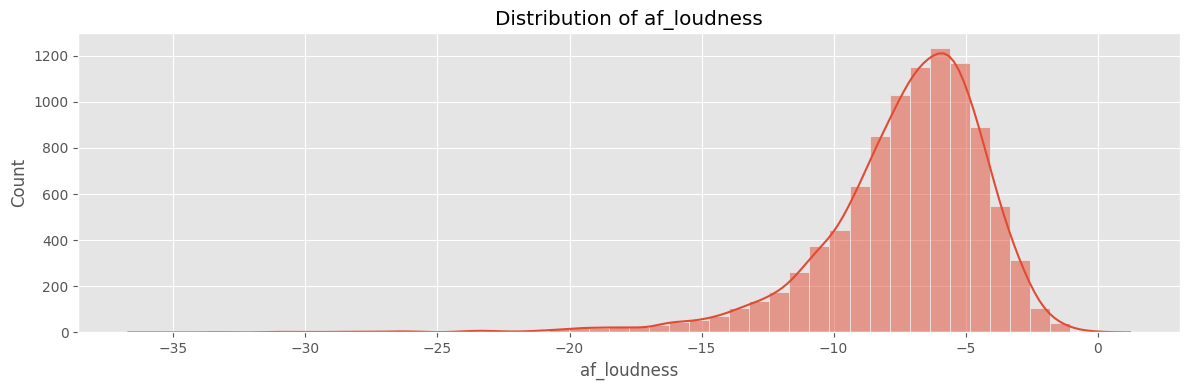

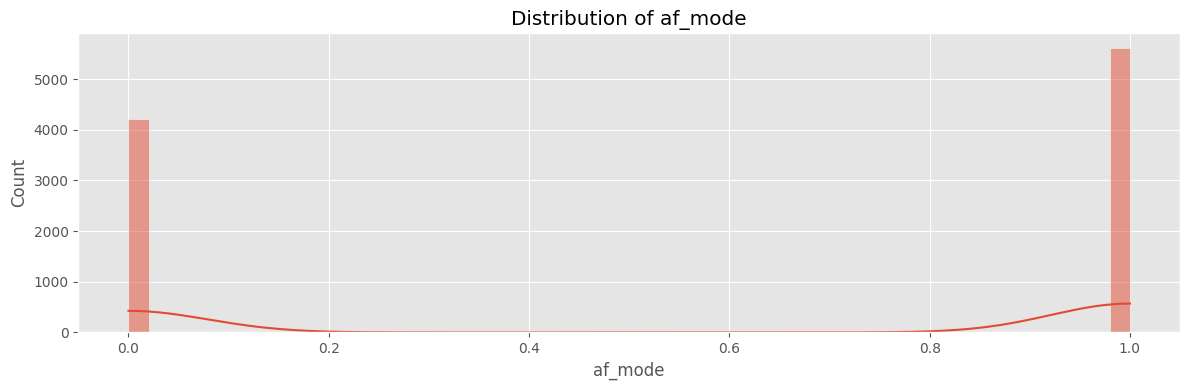

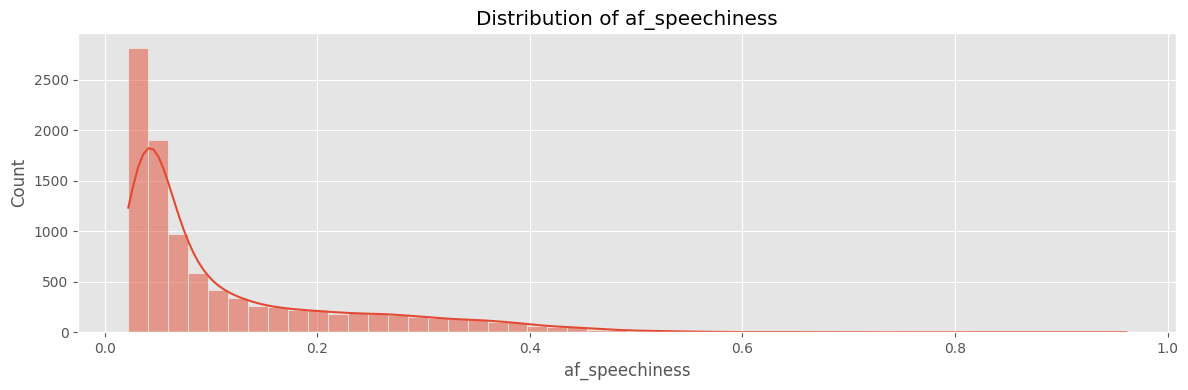

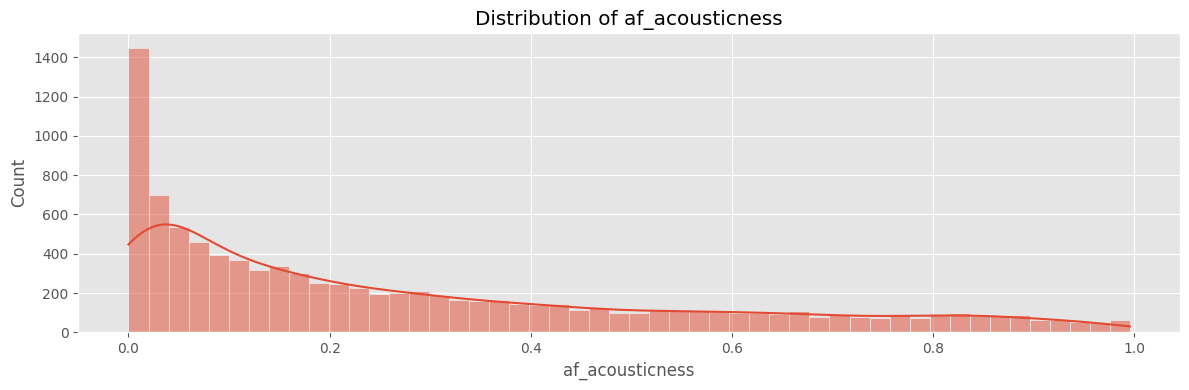

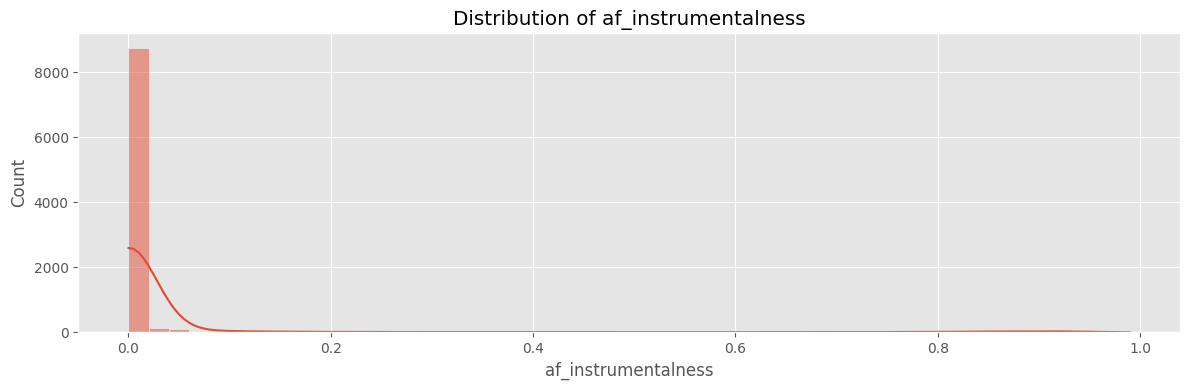

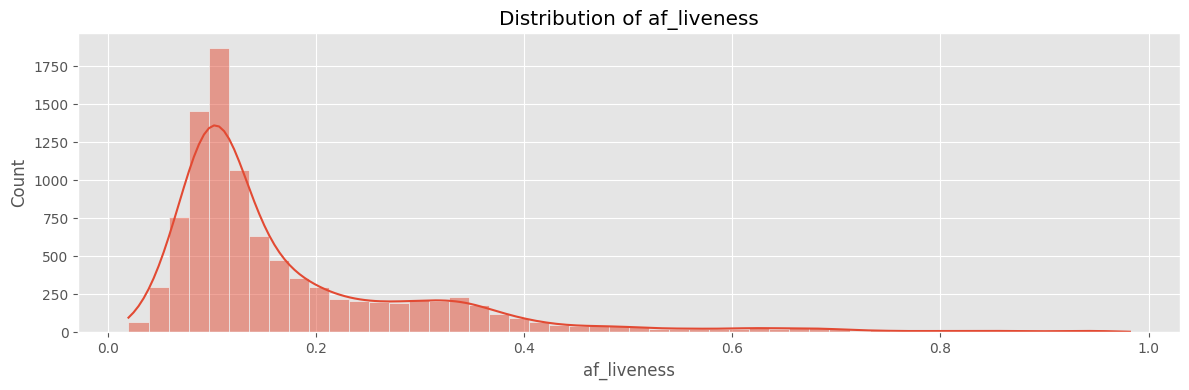

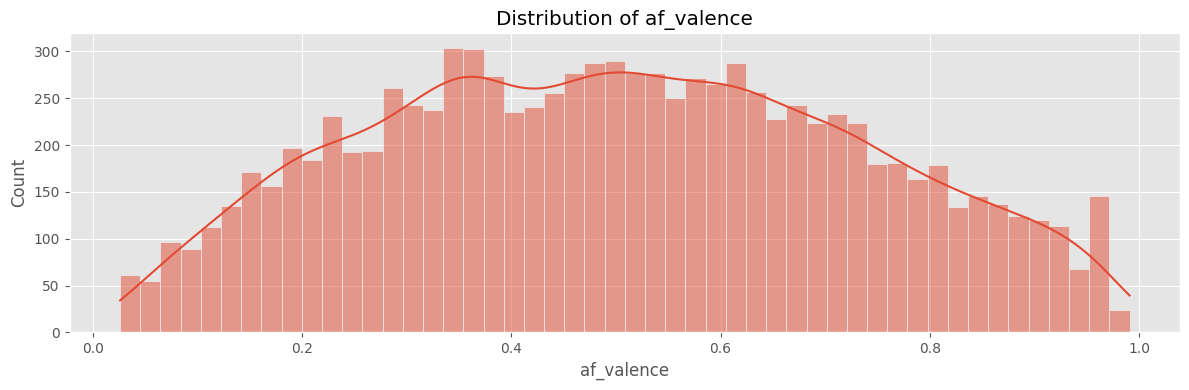

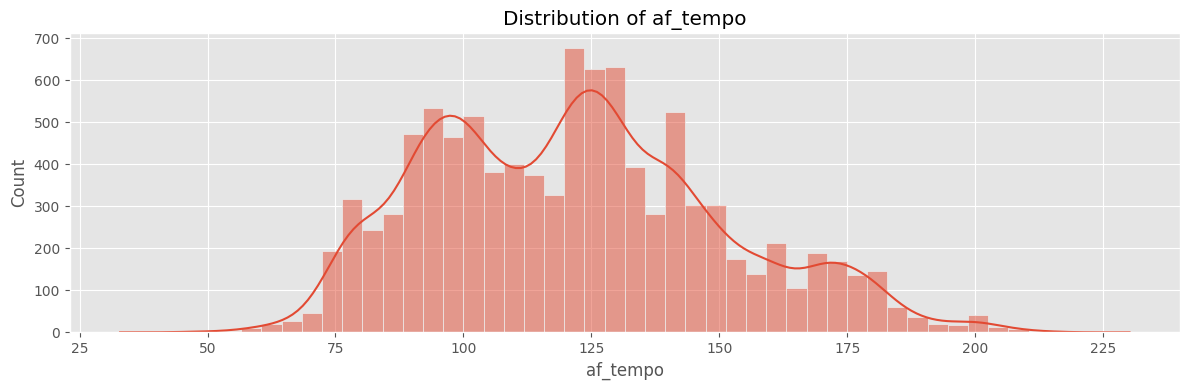

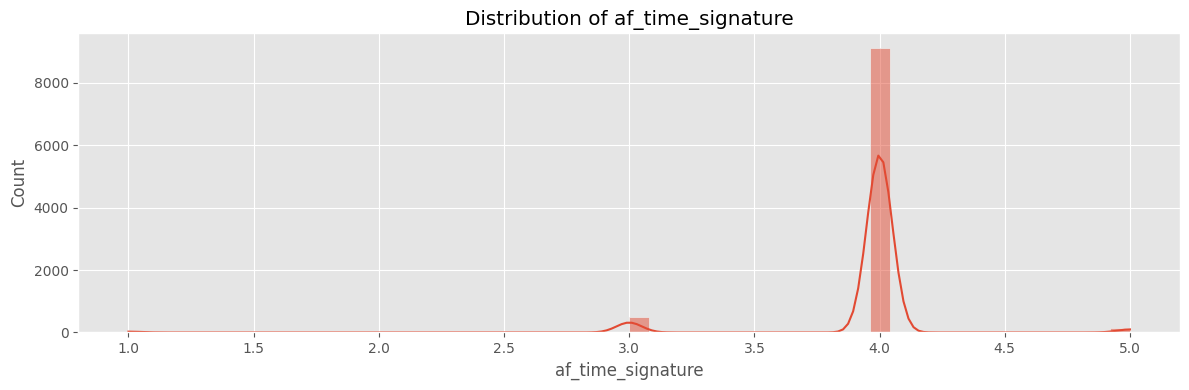

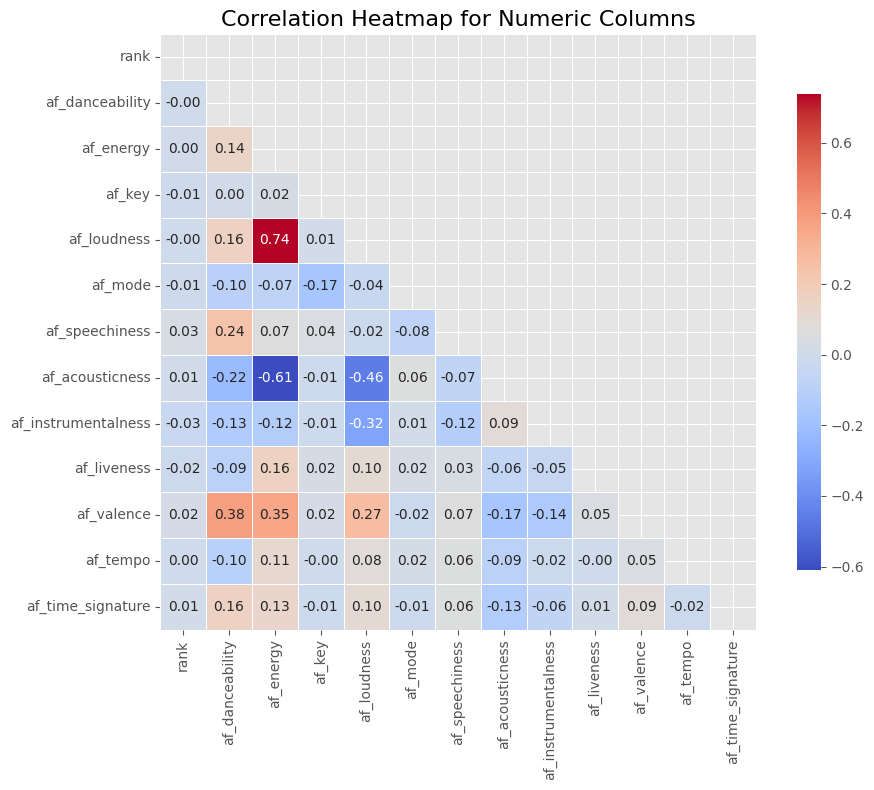


=== Rank vs Audio Features ===


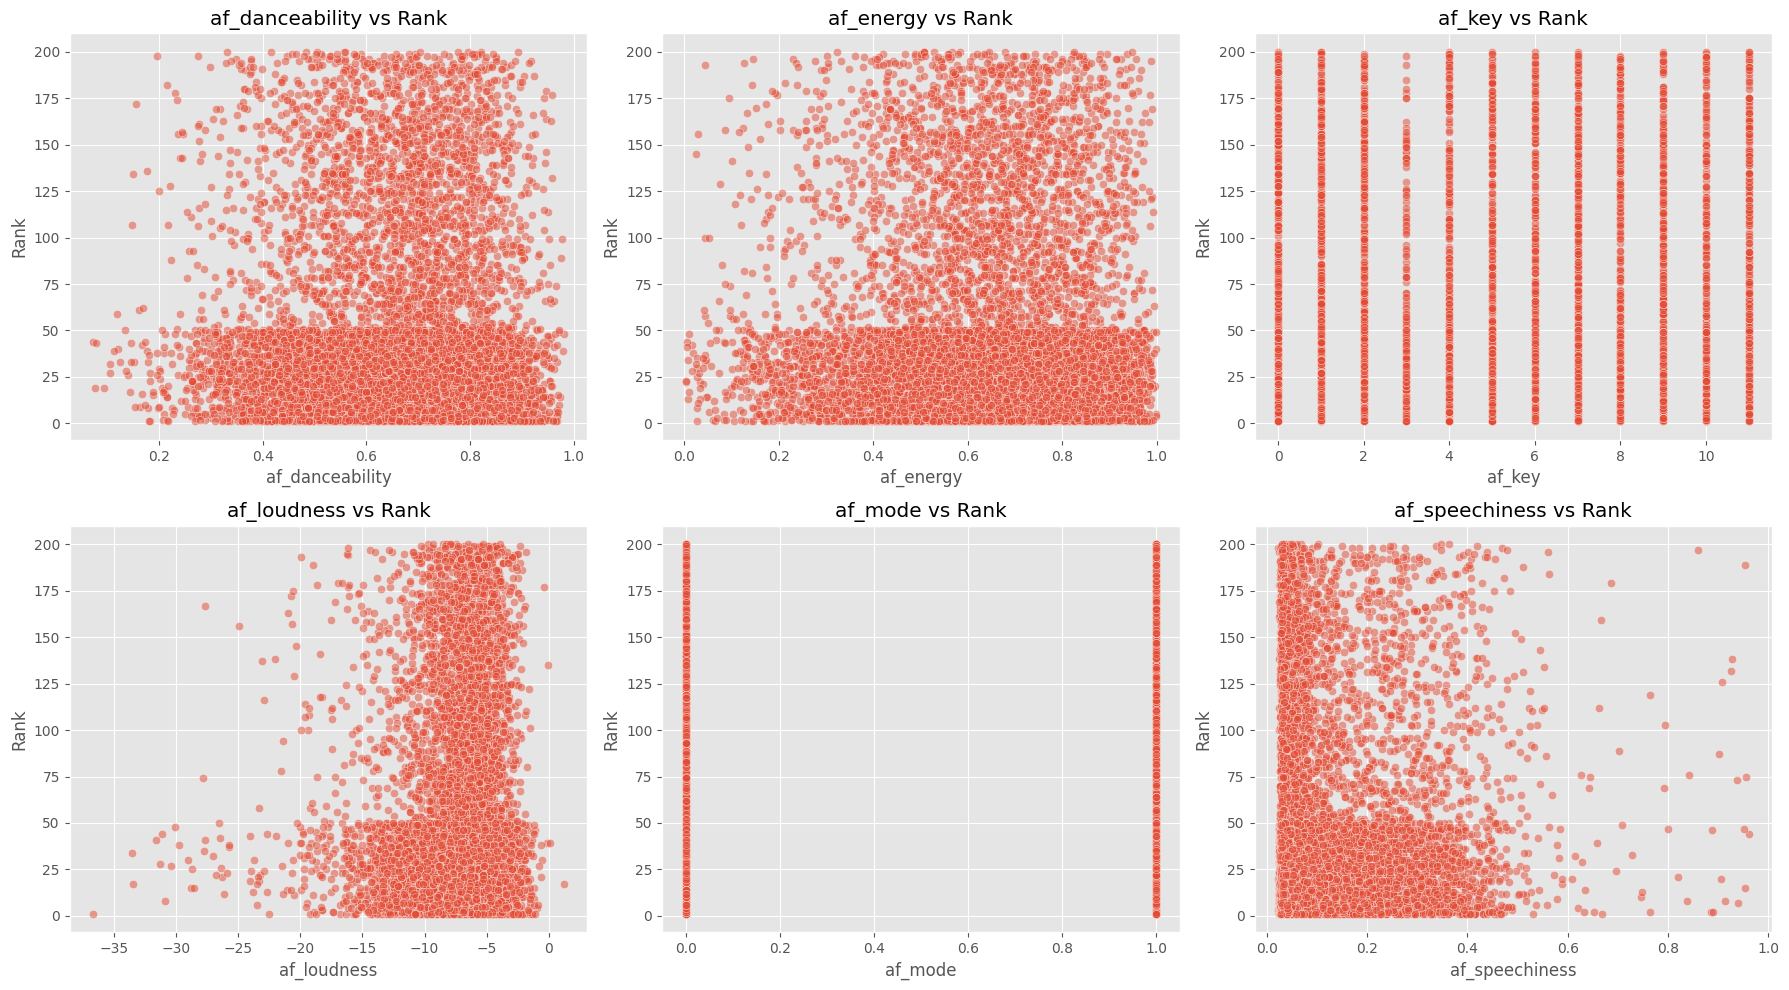


=== Boxplot of Rank by Region (Top 5 Regions) ===


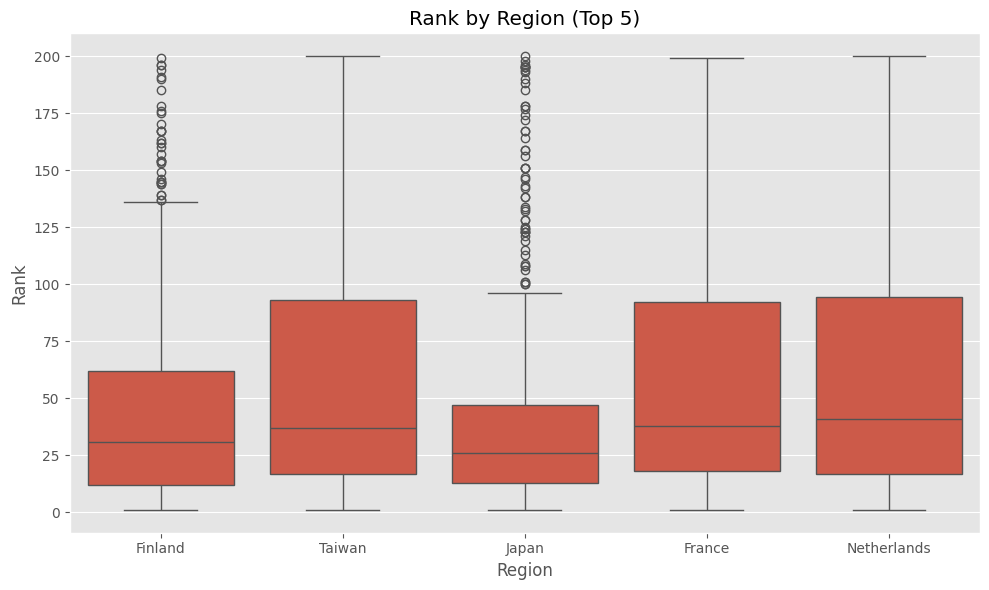


=== PCA on Audio Features ===
PCA Explained Variance Ratios: [0.22274918 0.11354807]


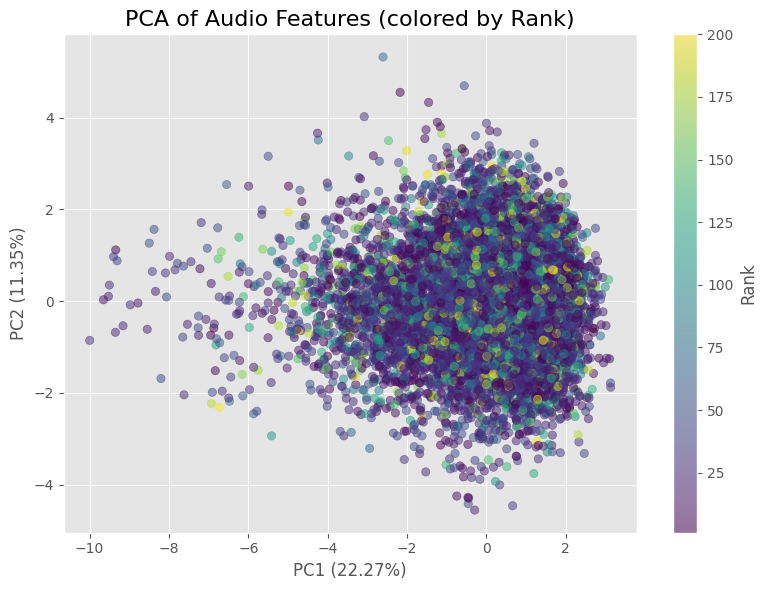


=== Top 20 Artists by Track Count ===


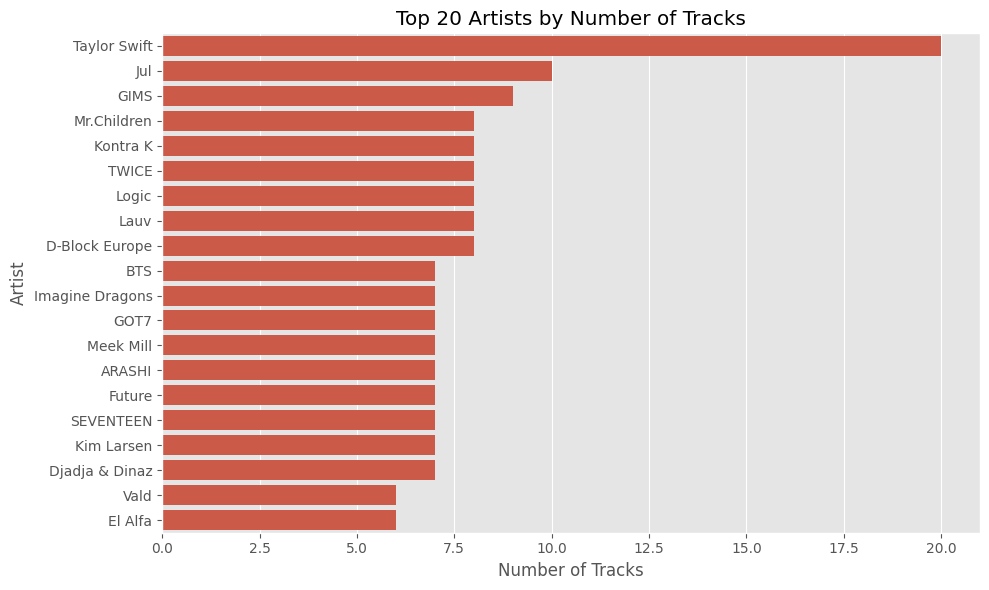


=== EDA Complete! ===


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1. Basic Overview
# ---------------------------
print("=== Basic Info ===")
print(df.info())
print("\n=== Descriptive Statistics (Numeric Columns) ===")
print(df.describe())
print(f"\nDataFrame Shape: {df.shape}")

# ---------------------------
# 2. Missing Values
# ---------------------------
print("\n=== Missing Values per Column ===")
missing_counts = df.isna().sum()
print(missing_counts)

# Optionally visualize missingness
# plt.figure(figsize=(10,6))
# sns.heatmap(df.isna(), cbar=False, cmap='viridis')
# plt.title("Missing Values Heatmap")
# plt.show()

# ---------------------------
# 3. Distribution of Key Numerical Columns
# ---------------------------
# Use 'rank' and all audio features (columns starting with 'af_')
numeric_cols = ['rank'] + [col for col in df.columns if col.startswith('af_')]

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col].dropna(), kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# ---------------------------
# 4. Correlation Heatmap for Numeric Columns
# ---------------------------
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, 
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap for Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

# ---------------------------
# 5. Scatter Plots: Rank vs Audio Features
# ---------------------------
print("\n=== Rank vs Audio Features ===")
audio_features = [col for col in df.columns if col.startswith('af_')]
# Limit to up to 6 features for brevity
features_to_plot = audio_features[:6]

plt.figure(figsize=(18, 10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=df[feature], y=df['rank'], alpha=0.5)
    plt.title(f'{feature} vs Rank')
    plt.xlabel(feature)
    plt.ylabel('Rank')
plt.tight_layout()
plt.show()

# ---------------------------
# 6. Boxplots: Rank by Region
# ---------------------------
if 'region' in df.columns:
    print("\n=== Boxplot of Rank by Region (Top 5 Regions) ===")
    top_regions = df['region'].value_counts().head(5).index
    subset_df = df[df['region'].isin(top_regions)]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='region', y='rank', data=subset_df)
    plt.title('Rank by Region (Top 5)')
    plt.xlabel('Region')
    plt.ylabel('Rank')
    plt.tight_layout()
    plt.show()

# ---------------------------
# 7. PCA on Audio Features
# ---------------------------
print("\n=== PCA on Audio Features ===")
af_df = df[audio_features].dropna()

if len(af_df) > 0:
    # Standardize the audio features
    scaler = StandardScaler()
    scaled_af = scaler.fit_transform(af_df)
    
    # Apply PCA with 2 components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_af)
    
    # Create a DataFrame with the PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    
    # Add additional information (rank and artist)
    pca_df['rank'] = df.loc[af_df.index, 'rank'].values
    if 'artist' in df.columns:
        pca_df['artist'] = df.loc[af_df.index, 'artist'].values
    
    print(f"PCA Explained Variance Ratios: {pca.explained_variance_ratio_}")
    
    # Plot PCA results, coloring points by rank
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                          c=pca_df['rank'], cmap='viridis', alpha=0.5)
    plt.title('PCA of Audio Features (colored by Rank)', fontsize=16)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    plt.colorbar(scatter, label='Rank')
    plt.tight_layout()
    plt.show()
else:
    print("No valid rows in audio features for PCA (all values might be NaN).")

# ---------------------------
# 8. Top Artists by Track Count
# ---------------------------
if 'artist' in df.columns:
    print("\n=== Top 20 Artists by Track Count ===")
    top_artists = df['artist'].value_counts().head(20)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_artists.values, y=top_artists.index)
    plt.title('Top 20 Artists by Number of Tracks')
    plt.xlabel('Number of Tracks')
    plt.ylabel('Artist')
    plt.tight_layout()
    plt.show()

print("\n=== EDA Complete! ===")
